### Assignment 4: TKO_7096-3001 Computer Vision and Sensor Fusion


Goal: develop a RGB-Depth fusion architecture for semantic segmentation based on Fully Convolutional Network (FCN) .


<font color='red'> Deadline: 25.03.2024 at 24:00.

- Imports go here

In [54]:
# Machine Learning libraries
import tensorflow as tf
from keras.utils import Sequence
from sklearn.preprocessing import OneHotEncoder
from keras.applications import resnet
from keras.utils import to_categorical
from keras.layers import Conv2D, Activation, Dropout, Concatenate, Conv2DTranspose
from keras.models import Model
from keras.optimizers import SGD

# Data manipulation libraries
import numpy as np
import cv2 as cv

# Visualization libraries
import matplotlib.pyplot as plt

# System libraries
import os

# Check GPU availability
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the dataset and Ground-truth###

- Dataset consists of 1100 (per modality) images of road scenes. It is divided into train (600 images), test (200 images) and validation (300 images) datasets.
- Change the size of all images into 256*256.
- Converting the labels into one hot encoding
- Create a DataLoader for loading the files when training the model.

In [55]:
# Here we want to create DataLoader class by using Sequence class from Keras
# The purpose of DataLoader class is to load data, then preprocess it, and finally return it to the model later.
class DataLoader(Sequence):
    # Here we want to initialize the DataLoader class with following parameters:

    # rgb_files: which is a list of RGB images file paths
    # depth_files: which is a list of depth images file paths
    # label_files: which is a list of label images file paths
    # batch_size: which is the size of each batch we want to load (this may increase the speed of training
    # so we may need to adjust it later)
    # num_classes: number of classes in the dataset (imporant for one-hot encoding)
    # indices: list of numpy array of indices of the dataset
    def __init__(self, rgb_files, depth_files, label_files, batch_size, num_classes):
        # Now do define the instance variables to each instances
        self.rgb_files = rgb_files
        self.depth_files = depth_files
        self.label_files = label_files
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.indices = np.arange(len(self.rgb_files))
        self.encoder = OneHotEncoder(categories='auto', sparse_output=False, handle_unknown='ignore')
        self.encoder.fit(np.arange(self.num_classes).reshape(-1, 1))
    
    # Now we define the length of the DataLoader class, which is the number of batces per epoch
    # Meaning that epoch * batch_size = number of samples
    def __len__(self):
        return int(np.floor(len(self.rgb_files) / self.batch_size))

    # This will generate the data for each batch.
    # Each batch will contain images of RGB, Depth, and data of labels
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_rgb_files = [self.rgb_files[i] for i in batch_indices]
        batch_depth_files = [self.depth_files[i] for i in batch_indices]
        batch_label_files = [self.label_files[i] for i in batch_indices]

        # Then we just return these batch files to the __generate_data method
        return self.__generate_data(batch_rgb_files, batch_depth_files, batch_label_files)
        
    # Finally, we load the data from the files and process them to have the correct resolution of 256x256.
    def __generate_data(self, batch_rgb_files, batch_depth_files, batch_label_files):
        X_rgb_load = [os.path.join("data/dataset/train/rgb/", f) for f in batch_rgb_files]
        X_depth_load = [os.path.join("data/dataset/train/depth/", f) for f in batch_depth_files]
        y_load = [os.path.join("data/dataset/train/label/", f) for f in batch_label_files]
        
        # Load the images from the files
        X_rgb = np.array([np.load(f) for f in X_rgb_load])
        X_depth = np.array([np.load(f) for f in X_depth_load])
        y = np.array([np.load(f) for f in y_load])

        # Resize the images and labels to 256x256
        X_rgb = np.array([cv.resize(img, (256, 256)) for img in X_rgb])
        # Resize depth also but include the last channel for the depth also
        X_depth = np.array([cv.resize(img, (256, 256))[:, :, np.newaxis] for img in X_depth])
        X_depth = np.repeat(X_depth, 3, axis=3)
        y = np.array([cv.resize(img, (160, 160)) for img in y])
    

        # One-hot encode the labels
        Y = to_categorical(y, num_classes=self.num_classes)
        return [X_rgb, X_depth], Y


# References for the code:
# https://docs.python.org/3/tutorial/classes.html
# https://keras.io/api/utils/python_utils/#sequence-class

- Visualize the data you have prepared 

(8, 256, 256, 3) (8, 256, 256, 3) (8, 160, 160, 19)


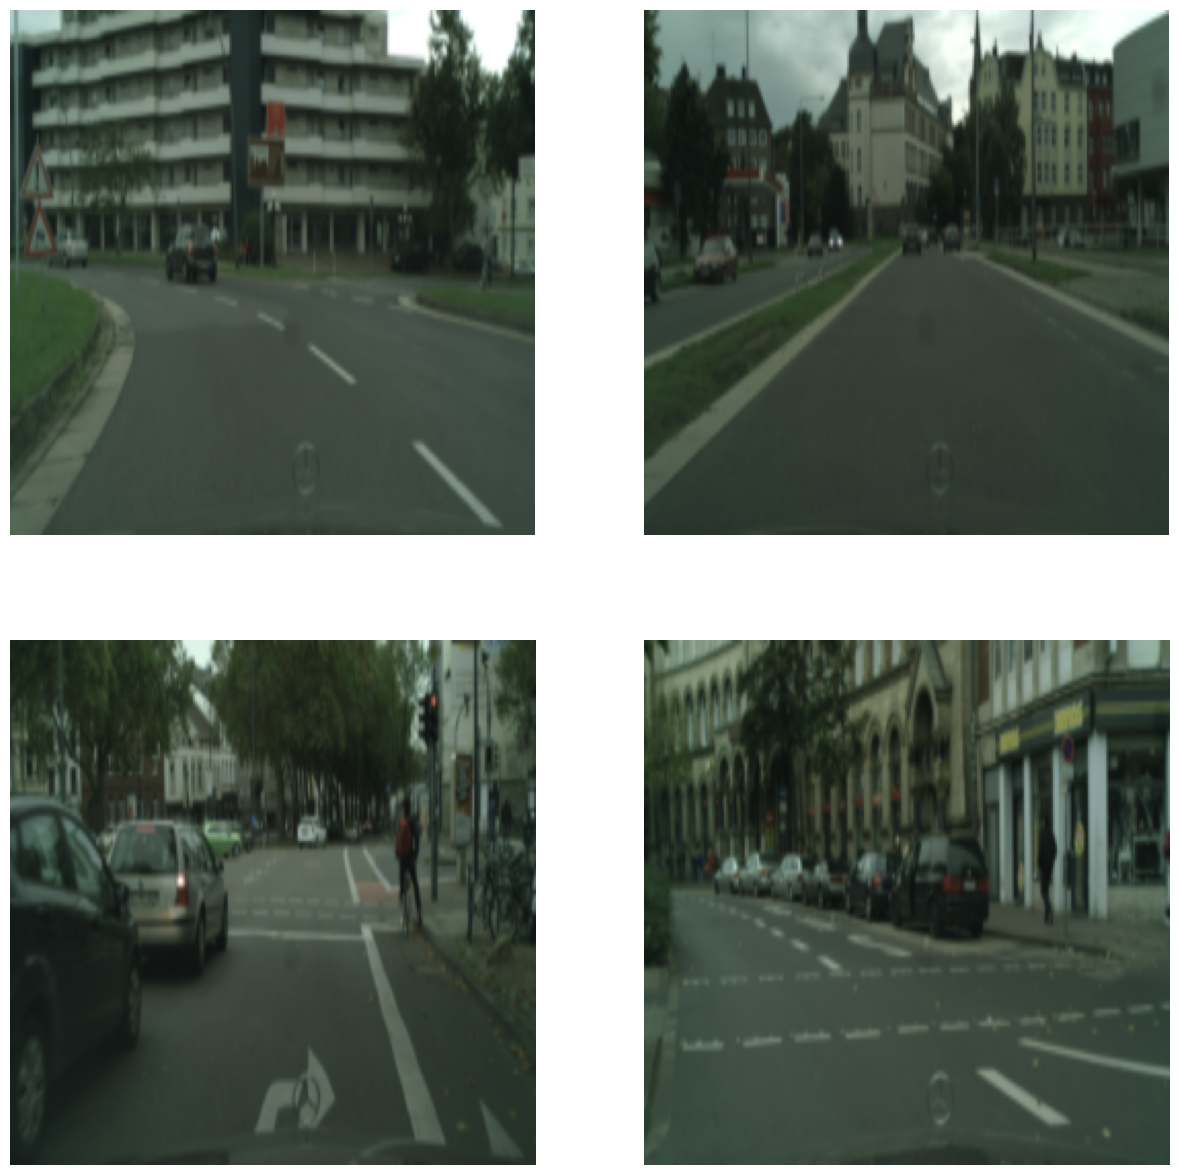

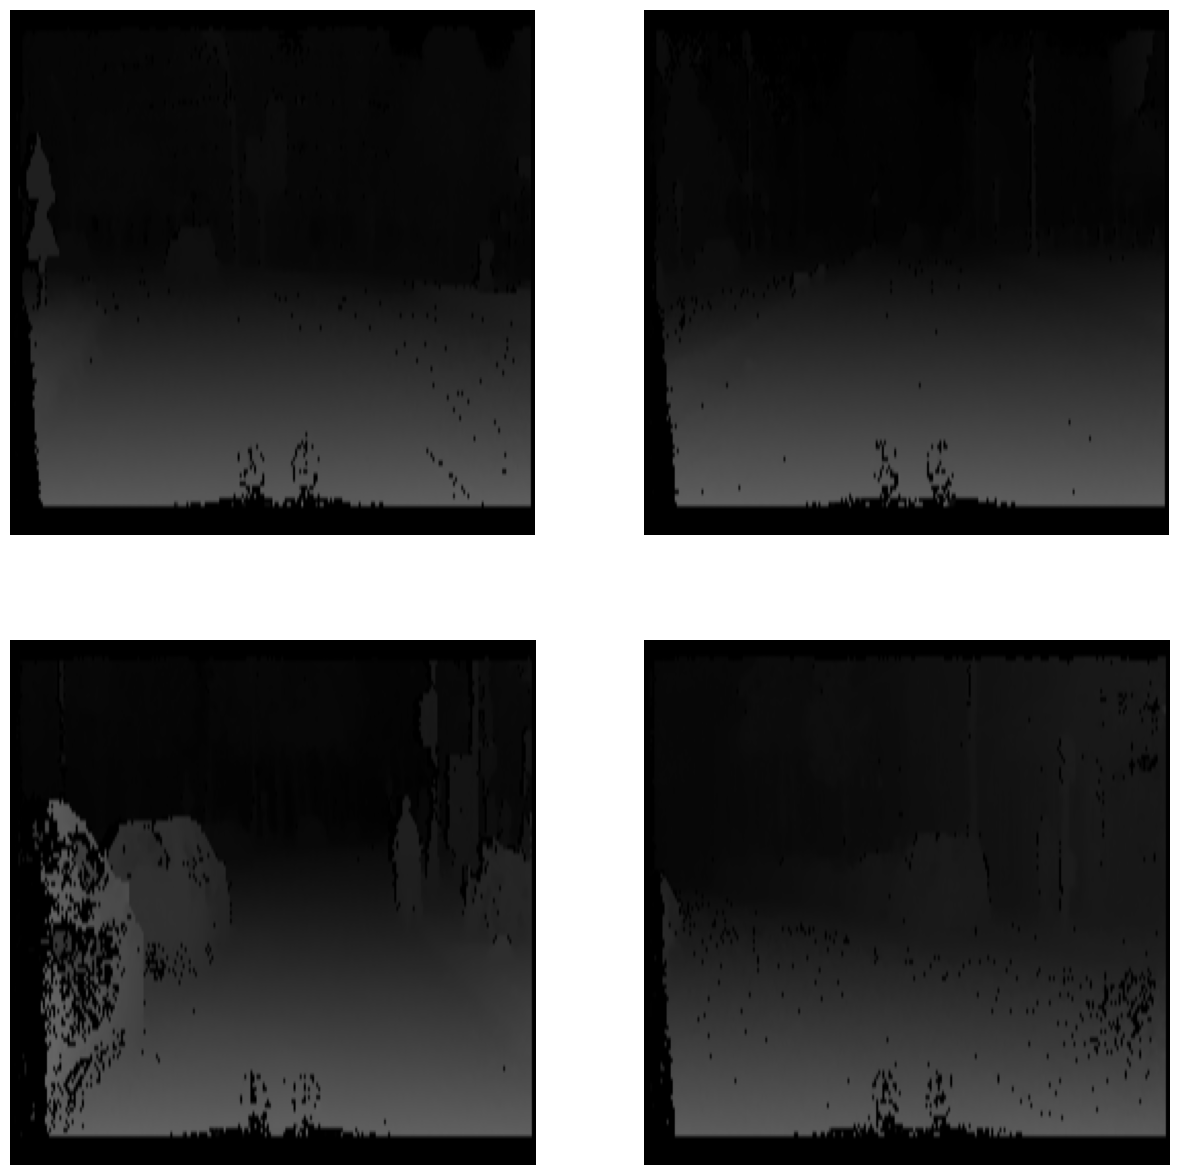

In [56]:
# Here I define all the file paths.
train_rgb_files = sorted(os.listdir('data/dataset/train/rgb/'))
train_depth_files = sorted(os.listdir('data/dataset/train/depth/'))
train_label_files = sorted(os.listdir('data/dataset/train/label/'))
val_rgb_files = sorted(os.listdir('data/dataset/validation/rgb/'))
val_depth_files = sorted(os.listdir('data/dataset/validation/depth/'))
val_label_files = sorted(os.listdir('data/dataset/validation/label/'))
test_rgb_files = sorted(os.listdir('data/dataset/test/rgb/'))
test_depth_files = sorted(os.listdir('data/dataset/test/depth/'))
test_label_files = sorted(os.listdir('data/dataset/test/label/'))

# Now we create all the DataLoader instances for trainign, validation, and testing.
train_loader = DataLoader(train_rgb_files, train_depth_files, train_label_files, batch_size=8, num_classes=19)
val_loader = DataLoader(val_rgb_files, val_depth_files, val_label_files, batch_size=8, num_classes=19)
test_loader = DataLoader(test_rgb_files, test_depth_files, test_label_files, batch_size=8, num_classes=19)

# Test the DataLoader class
# We load the first batch of the training data
X, y = train_loader[0]
# Print the shape information of each data classes
print(X[0].shape, X[1].shape, y.shape)

# Now we want to visualize the data for RGB and Depth images
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[0][i])
    ax.axis('off')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[1][i])
    ax.axis('off')
plt.show()

We can see that now all the images have a resolution of 256x256, and the four lower images have their depth data. So far, I believe that the RGB images give better information about the different categories, because in these images the colours are more easily visible. In any case, depth images give better information about small shapes and objects close to the camera, which may increase performance later.

 Define a Fully Convolutional Network (FCN) for image segmentaion by fusing RGB and depth images. The network consists of  two sterams which each stream has following layers:

    1. Use the pretrained ResNet50 on imageNet
    2. Add two Conv layers with 128 and 256 nodes, respectively. Kernel size (3,3), stride (1,1)
    3. Top of the Conv layers, add dropout layer with 0.2
    4. Concatenate two streams.
    5. Add a transposed convolution layer (Conv2DTranspose)  with Kernel size (64,64), stride (32,32)
    6. Add a softmax activation layer
    
 You can find the model summary and structure in the PDF file.


In [57]:
# Lets start by creating a input layer for our model
input_rgb = tf.keras.layers.Input(shape=(256, 256, 3), name='resnet50_rgb')
input_depth = tf.keras.layers.Input(shape=(256, 256, 3), name='resnet50_depth')

# Now we create a ResNet50 model with ImageNet weights
resnet50 = resnet.ResNet50(include_top=False, weights='imagenet')

# We apply both rgb and depth images to the ResNet50 model and get the features from the model
features_rgb = resnet50(input_rgb)
features_depth = resnet50(input_depth)

# We add two Conv layers with 128 and 256 nodes, where the Kernel size is 3x3 and stride 1x1
conv_rgb = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', name='conv_rgb1')(features_rgb)
conv_rgb = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', name='conv_rgb2')(conv_rgb)
# We add the dropout layer with 0.2
conv_rgb = Dropout(0.2)(conv_rgb)

# Same process here for the depth images
conv_depth = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', name='conv_depth1')(features_depth)
conv_depth = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', name='conv_depth2')(conv_depth)
conv_depth = Dropout(0.2)(conv_depth)

# Now we concatenate the features from RGB and Depth iamges
# Here happens the "fusion process"
concat = Concatenate()([conv_rgb, conv_depth])

# Add a transposed conv layer with kernel size fo 64x64 and stride of 32x32
transposed_conv = Conv2DTranspose(19, (64, 64), strides=(32, 32), activation='relu', name='transposed_conv')(concat)

# And finally we create the softmax activation layer
output = Activation('softmax')(transposed_conv)

# Define the model 
model = Model(inputs=[input_rgb, input_depth], outputs=output)

# Reference for the code:
# https://keras.io/api/applications/resnet/
# https://keras.io/api/models/model/


Compile the model with SGD(learning_rate=0.01, decay=1e-5, momentum=0.9) and loss="categorical_crossentropy"

Train the model on the “train” dataset  and “validation”dataset for epochs =10. 

In [58]:
# Compile the model with SGD and earlier listed parameters
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 resnet50_rgb (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50_depth (InputLayer)    [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, None, None,   23587712    ['resnet50_rgb[0][0]',           
                                2048)                             'resnet50_depth[0][0]']   

In [59]:
# Train the model
model.fit(train_loader,
          epochs=10,
          validation_data=val_loader,
          validation_steps=len(val_loader)
    )

Epoch 1/10
75/75 [==============================] - 24s 256ms/step - loss: 2.3057 - accuracy: 0.3779 - val_loss: 2.1333 - val_accuracy: 0.4388
Epoch 2/10
75/75 [==============================] - 17s 222ms/step - loss: 1.4297 - accuracy: 0.5509 - val_loss: 2.1403 - val_accuracy: 0.4334
Epoch 3/10
75/75 [==============================] - 17s 221ms/step - loss: 1.2928 - accuracy: 0.5814 - val_loss: 2.0939 - val_accuracy: 0.4046
Epoch 4/10
75/75 [==============================] - 17s 221ms/step - loss: 1.1817 - accuracy: 0.6331 - val_loss: 2.0197 - val_accuracy: 0.4589
Epoch 5/10
75/75 [==============================] - 17s 220ms/step - loss: 1.0839 - accuracy: 0.6815 - val_loss: 1.6395 - val_accuracy: 0.5267
Epoch 6/10
75/75 [==============================] - 17s 222ms/step - loss: 1.0174 - accuracy: 0.7060 - val_loss: 1.5689 - val_accuracy: 0.5287
Epoch 7/10
75/75 [==============================] - 17s 221ms/step - loss: 0.9572 - accuracy: 0.7261 - val_loss: 1.2980 - val_accuracy: 0.6324

 Evaluate the model on the training and test dataset. The results must be shown as 

- Print loss and accuracy of model for  test dataset.

- Predict semantically segmented images on 5 random example of test dataset.

- Visualize the 5 random examples alongside the ground truth and prediction.

25/25 [==============================] - 2s 73ms/step - loss: 0.9360 - accuracy: 0.7408
Real World Loss: 0.936038613319397
Real World Accuracy: 0.7407775521278381
1/1 [==============================] - 1s 880ms/step


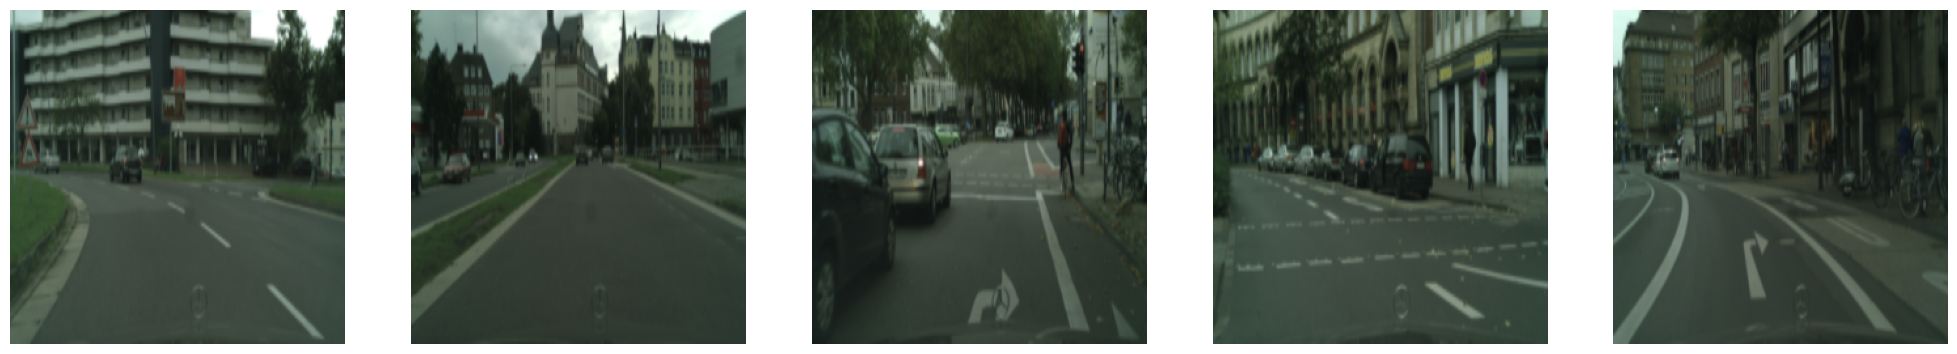

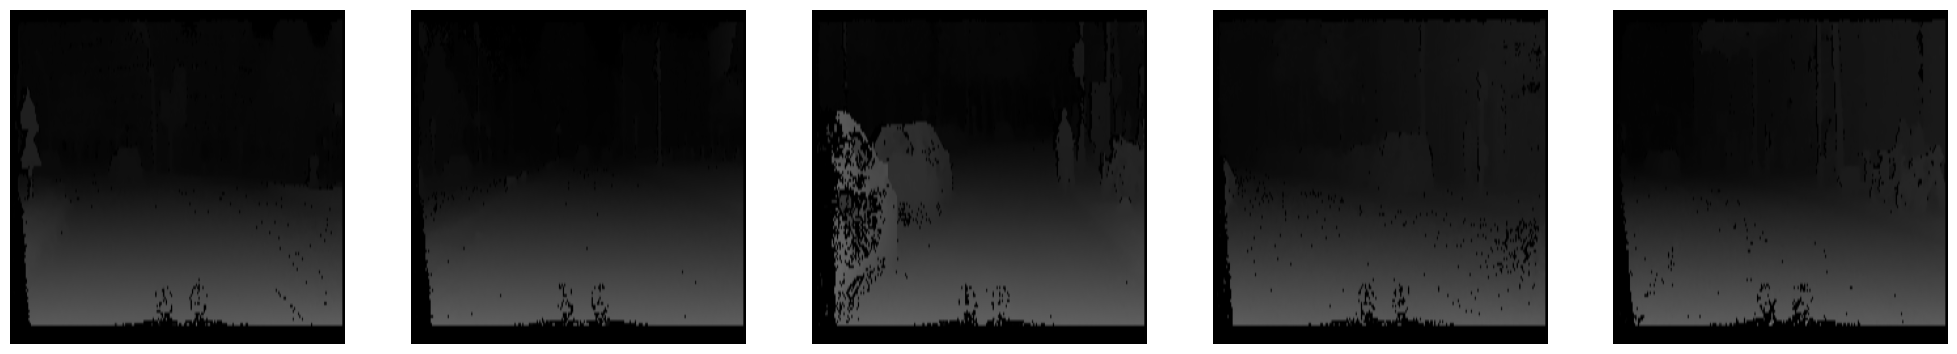

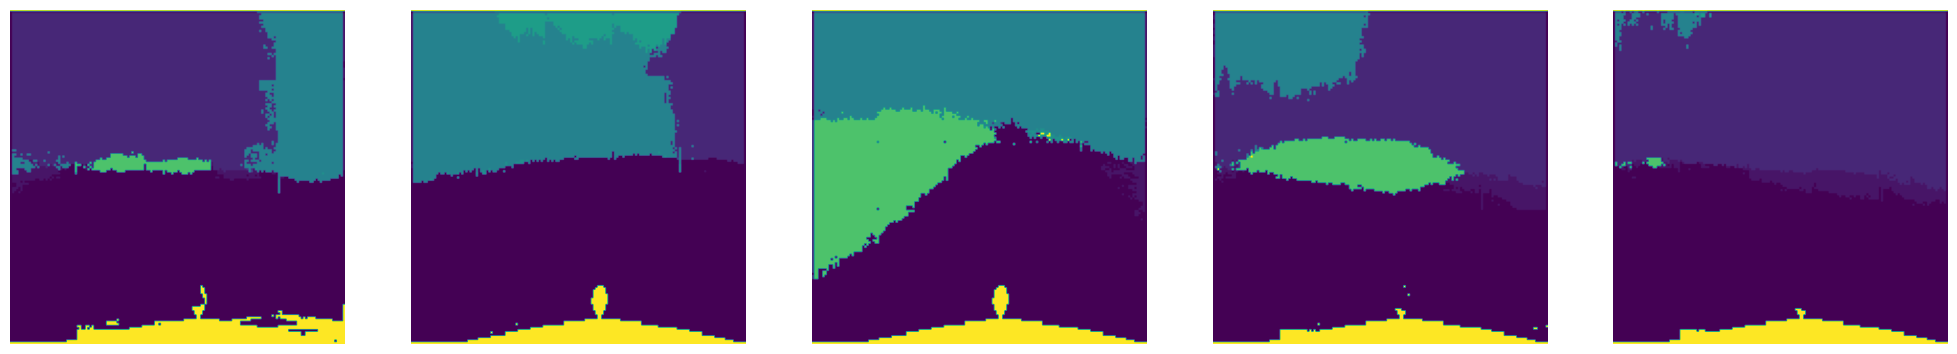

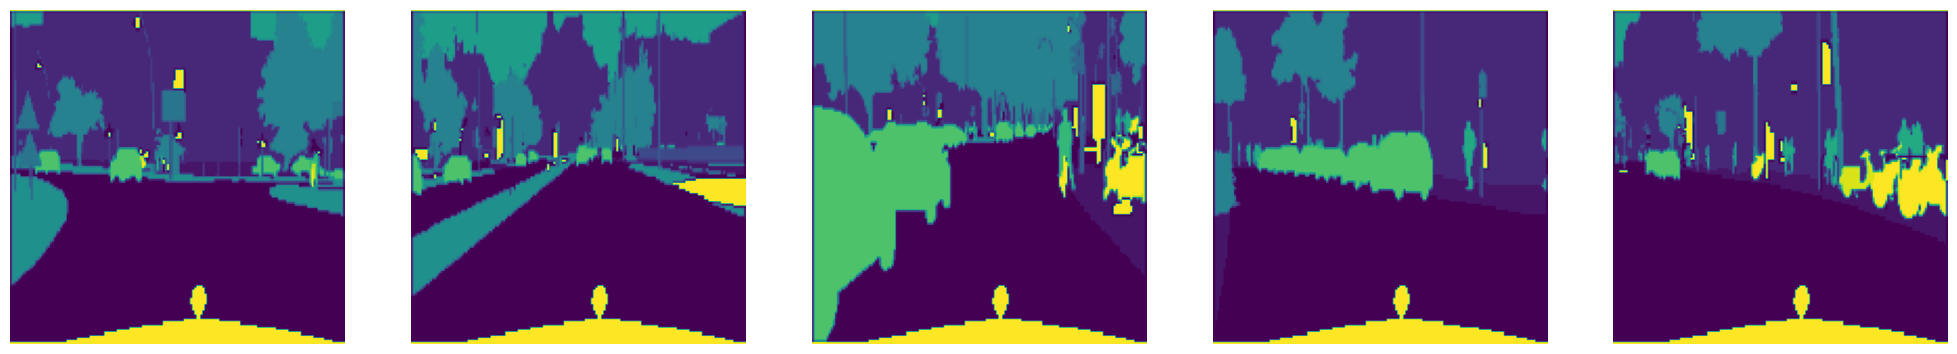

In [60]:
# Now print the loss and accuracy of the model
test_loss, test_accuracy = model.evaluate(test_loader)
print('Real World Loss:', test_loss)
print('Real World Accuracy:', test_accuracy)

# Now we want to predict semantically segmented images on 5 random images from the test dataset
X, y = test_loader[0]
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=3)

# Now we print the rgb images
fig, axes = plt.subplots(1, 5, figsize=(25, 25))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[0][i])
    ax.axis('off')
plt.show()

# Depth images
fig, axes = plt.subplots(1, 5, figsize=(25, 25))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[1][i])
    ax.axis('off')
plt.show()

# Predicted segmentation labels
fig, axes = plt.subplots(1, 5, figsize=(25, 25))
for i, ax in enumerate(axes.flat):
    ax.imshow(y_pred[i])
    ax.axis('off')
plt.show()

# Real labels
fig, axes = plt.subplots(1, 5, figsize=(25, 25))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.argmax(y[i], axis=2))
    ax.axis('off')
plt.show()

Using the test data, we obtained a loss value of about 0.94 and an accuracy of 0.74. From the third row we can see that our model did indeed predict some areas quite well. Although our accuracy and loss were not very high, we can see that there are still areas where the colours were not perfectly predicted. For example, in Images 1, 3 and 5, we can see that our model only correctly found large segments such as asphalt and building, but smaller segments were not found that well. The model should be trained more to find objects such as pedestrians or road signs, etc.

### Extra 5 points :

Implement FCNs for each sing modality and compare their accuracy with fusion model. I need the result of the following table in the same notebook. 

In [61]:
# Now lets implement the new model with the same architecture but only witht the RGB images
# We will use the same architecture as before but only with RGB images
# Input layer
input_rgb = tf.keras.layers.Input(shape=(256, 256, 3), name='resnet50_rgb')

# We use ResNet50 also here with ImageNet weights
resnet50 = resnet.ResNet50(include_top=False, weights='imagenet')

# Apply the RGB images again to the ResNet50
features_rgb = resnet50(input_rgb)

# Add two Conv layers with same properties as before
conv_rgb = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', name='conv_rgb1')(features_rgb)
conv_rgb = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', name='conv_rgb2')(conv_rgb)
conv_rgb = Dropout(0.2)(conv_rgb)

# Transposed conv layer also with same properties as before
transposed_conv = Conv2DTranspose(19, (64, 64), strides=(32, 32), activation='relu', name='transposed_conv')(conv_rgb)

# Activation lyaer
output = Activation('softmax')(transposed_conv)

# Define the model
model_rgb = Model(inputs=input_rgb, outputs=output)


# Compine the model with SGD and same parameters as before
model_rgb.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model_rgb.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_rgb (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 conv_rgb1 (Conv2D)          (None, 6, 6, 128)         2359424   
                                                                 
 conv_rgb2 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 dropout_12 (Dropout)        (None, 4, 4, 256)         0         
                                                                 
 transposed_conv (Conv2DTran  (None, 160, 160, 19)     19922963  
 spose)                                                          
                                                           

In [62]:
# Here we can create a new DataLoader class that only loads the RGB images and labels
# We can use the same DataLoader class as earlier but use it as a parent class and create
# a new class that.
class RGBDataLoader(DataLoader):
    def __getitem__(self, index):
        X, Y = super().__getitem__(index)
        X_rgb = X[0]
        return X_rgb, Y
    
train_loader_rgb = RGBDataLoader(train_rgb_files, train_depth_files, train_label_files, batch_size=8, num_classes=19)
val_loader_rgb = RGBDataLoader(val_rgb_files, val_depth_files, val_label_files, batch_size=8, num_classes=19)
test_loader_rgb = RGBDataLoader(test_rgb_files, test_depth_files, test_label_files, batch_size=8, num_classes=19)

# Let's train the model
# We want to take index 0 from the train_loader and val_loader
# Because we only want to use the RGB images here
model_rgb.fit(
    train_loader_rgb, 
    epochs=10,
    validation_data=val_loader_rgb,
    validation_steps=len(val_loader_rgb)
    )

Epoch 1/10
75/75 [==============================] - 14s 139ms/step - loss: 2.3799 - accuracy: 0.3587 - val_loss: 2.2569 - val_accuracy: 0.4100
Epoch 2/10
75/75 [==============================] - 10s 128ms/step - loss: 1.4418 - accuracy: 0.5506 - val_loss: 2.2783 - val_accuracy: 0.3513
Epoch 3/10
75/75 [==============================] - 9s 125ms/step - loss: 1.3142 - accuracy: 0.5694 - val_loss: 2.2899 - val_accuracy: 0.3293
Epoch 4/10
75/75 [==============================] - 8s 113ms/step - loss: 1.2213 - accuracy: 0.6036 - val_loss: 2.2328 - val_accuracy: 0.3766
Epoch 5/10
75/75 [==============================] - 8s 111ms/step - loss: 1.1225 - accuracy: 0.6592 - val_loss: 2.1866 - val_accuracy: 0.3709
Epoch 6/10
75/75 [==============================] - 9s 117ms/step - loss: 1.0602 - accuracy: 0.6866 - val_loss: 2.1178 - val_accuracy: 0.4368
Epoch 7/10
75/75 [==============================] - 10s 130ms/step - loss: 0.9965 - accuracy: 0.7117 - val_loss: 1.9200 - val_accuracy: 0.5022
Epo

In [63]:
# Now we do another model, but this time we only use the depth images
input_depth = tf.keras.layers.Input(shape=(256, 256, 3), name='resnet50_depth')

resnet50 = resnet.ResNet50(include_top=False, weights='imagenet')

features_depth = resnet50(input_depth)

conv_depth = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', name='conv_depth1')(features_depth)
conv_depth = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', name='conv_depth2')(conv_depth)
conv_depth = Dropout(0.2)(conv_depth)

transposed_conv = Conv2DTranspose(19, (64, 64), strides=(32, 32), activation='relu', name='transposed_conv')(conv_depth)

output = Activation('softmax')(transposed_conv)

model_depth = Model(inputs=input_depth, outputs=output)

model_depth.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model_rgb.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_rgb (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 conv_rgb1 (Conv2D)          (None, 6, 6, 128)         2359424   
                                                                 
 conv_rgb2 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 dropout_12 (Dropout)        (None, 4, 4, 256)         0         
                                                                 
 transposed_conv (Conv2DTran  (None, 160, 160, 19)     19922963  
 spose)                                                          
                                                           

In [64]:
# Now do the same process to get depth only FCN

# Again we create a new class that only loads the depth images and labels
class DepthDataLoader(DataLoader):
    def __getitem__(self, index):
        X, Y = super().__getitem__(index)
        X_rgb = X[1]
        return X_rgb, Y
    
train_loader_depth = DepthDataLoader(train_rgb_files, train_depth_files, train_label_files, batch_size=8, num_classes=19)
val_loader_depth = DepthDataLoader(val_rgb_files, val_depth_files, val_label_files, batch_size=8, num_classes=19)
test_loader_depth = DepthDataLoader(test_rgb_files, test_depth_files, test_label_files, batch_size=8, num_classes=19)

# Now we train the model again
model_depth.fit(
    train_loader_depth, 
    epochs=10,
    validation_data=val_loader_depth,
    validation_steps=len(val_loader_depth)
    )

Epoch 1/10
75/75 [==============================] - 13s 137ms/step - loss: 2.4411 - accuracy: 0.3439 - val_loss: 2.1595 - val_accuracy: 0.4115
Epoch 2/10
75/75 [==============================] - 9s 115ms/step - loss: 1.4662 - accuracy: 0.5532 - val_loss: 1.9516 - val_accuracy: 0.4935
Epoch 3/10
75/75 [==============================] - 8s 113ms/step - loss: 1.3074 - accuracy: 0.5715 - val_loss: 1.8752 - val_accuracy: 0.4577
Epoch 4/10
75/75 [==============================] - 8s 112ms/step - loss: 1.2275 - accuracy: 0.5944 - val_loss: 2.2299 - val_accuracy: 0.3509
Epoch 5/10
75/75 [==============================] - 8s 112ms/step - loss: 1.1830 - accuracy: 0.6054 - val_loss: 2.3056 - val_accuracy: 0.3418
Epoch 6/10
75/75 [==============================] - 8s 112ms/step - loss: 1.1270 - accuracy: 0.6317 - val_loss: 2.1479 - val_accuracy: 0.3552
Epoch 7/10
75/75 [==============================] - 8s 113ms/step - loss: 1.0801 - accuracy: 0.6523 - val_loss: 2.1110 - val_accuracy: 0.3661
Epoch

In [65]:
# Now finally print the loss and accuracy of the all models on with the test data.

# RGB + Depth model
test_loss, test_accuracy = model.evaluate(test_loader)
print('RGB and Depth Fusion Loss:', test_loss)
print('RGB and Depth Fusion Accuracy:', test_accuracy)

# Only RGB modle
test_loss, test_accuracy = model_rgb.evaluate(test_loader_rgb)
print('RGB Only Loss:', test_loss)
print('RGB Only Accuracy:', test_accuracy)

# Only Depth model
test_loss, test_accuracy = model_depth.evaluate(test_loader_depth)
print('Depth Only Loss:', test_loss)
print('Depth Only Accuracy:', test_accuracy)

25/25 [==============================] - 2s 72ms/step - loss: 0.9360 - accuracy: 0.7408
RGB and Depth Fusion Loss: 0.936038613319397
RGB and Depth Fusion Accuracy: 0.7407775521278381
25/25 [==============================] - 1s 37ms/step - loss: 1.2580 - accuracy: 0.6443
RGB Only Loss: 1.2580081224441528
RGB Only Accuracy: 0.6442552804946899
25/25 [==============================] - 1s 37ms/step - loss: 2.2149 - accuracy: 0.3290
Depth Only Loss: 2.2149012088775635
Depth Only Accuracy: 0.32901328802108765


# RESULT

| **Modality** | **Test Accuracy(%)** |
| -------- | -------- |
| RGB only | ≈ 64.4 % |
| Depth Only | ≈ 32.9 % |
| RBB and Depth Fusion | ≈ 74.1 % |

From these results we can see that RGB and Depth Fusion is actually giving the best result in real world accuracy. The depth only model gives a really poor accuracy, but as seen earlier, the depth images were not very informative if its compared to the RGB images.

In conclusions, we can say that the RGB and Depth Fusion model works quite well, but it is not giving very preciese results. To make this model even better, we could add more epochs and increase the accuracy, but slow down the total time of training. We can also add more data to make better predictions. I think that even decreasing the amount of labels, could possibly give better performance, because if we look the predictions and their images, we can see that there is actually not 19 classes visible, even in the ground truth images.